# TL;DR
* Altair hard fork of Ethereum's beacon chain (consensus layer) planned for late September
* Altair introduces sync committees for light client functionality, and reforms to validator rewards/penalties which will impact on validator profitability
* The relative increase in proposer rewards, and the introduction of sync committee rewards will increase the variability of total rewards; this particularly impacts solo stakers
* Although net neutral in the ideal case, Altair introduces harsher penalties for delayed attestations, and will result in a net reduction in issuance
* Validators advised to keep an eye on attestation delay performance; those whose attestations are frequently delayed likely to be much less profitable after Altair


# Introduction
In the [last article](https://pintail.xyz/posts/validator-rewards-in-practice/) we looked at the real world performance of validators on Ethereum's beacon chain — now generally known as the "consensus layer". With the beacon chain running smoothly since launch in December 2020 (with only a couple of [minor](https://medium.com/prysmatic-labs/eth2-mainnet-incident-retrospective-f0338814340c) [hiccups](https://blog.lido.fi/lido-20-08-2021-orphaned-blocks-in-ethereum-incident-postmortem/)), many people will have had their attention on the deployment of the [London hard fork](https://blog.ethereum.org/2021/07/15/london-mainnet-announcement/) (including the widely discussed EIP-1559 fee market change) and the coming eth1+eth2 merge, when Ethereum's execution layer will switch to using the beacon chain for consensus, meaning an end to Proof of Work mining.

Meanwhile, with less fanfare, consensus client developers have been focused on the beacon chain's first upgrade, known as Altair. This fork will introduce light client functionality and will serve as the first test of coordinating a fork on Ethereum's Proof of Stake consensus mechanism. The Altair specification applies some lessons learned since the beacon chain's launch to improve its incentivisation structure and performance, in part by making some alterations to the way rewards and penalties are allocated, and therefore will impact to some degree on validator rewards.

In this article, we're going to focus on the economic changes coming Altair. We'll try and understand the likely impact on the validators, using data from mainnet (and some assumptions) to see how validator rewards would have been different, had Altair been active since beacon chain genesis. This will help validators to know what to expect when the fork hits, currently expected at the end of September, following [upgrades on the Pyrmont and Prater testnets](https://blog.ethereum.org/2021/08/25/finalized-no-28/).


# Reward Scheme Changes

The first change to understand is that in the concept of *base reward* means something slightly different under Altair. Previously a base reward was the basic unit of rewards allocated per epoch, with up to one whole base reward available for performing *each* of the four validator duties (source vote, target vote, head vote, prompt inclusion). However, under Altair we redefine base reward, such that it is the long run average per-epoch reward that would be paid to a perfect validator for fulfilling *all* of its duties. We keep the maximum issuance the same as before, but rather than multiples of the base reward, validators are rewarded with fractions of the base reward for each of their duties.

## Reward Weights

In addition to redefining the meaning of *base reward*, the weightings allocated to the various duties, and indeed the duties themselves have been altered. The charts below illustrate the "before" and "after" allocations, assuming perfect validator performance.

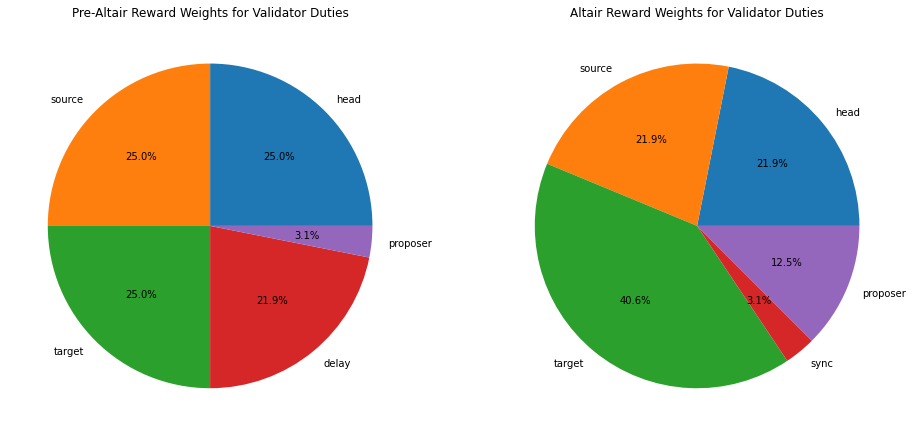

In [1]:
# plot reward allocation

import matplotlib.pyplot as plt

head = 1
source = 1
target = 1
delay = 7/8
proposer = 1/8

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,10))

ax1.pie(
    [head, source, target, delay, proposer],
    labels=['head', 'source', 'target', 'delay', 'proposer'],
    autopct='%1.1f%%'
)
ax1.set_title(
    "Pre-Altair Reward Weights for Validator Duties"
)

HEAD_WEIGHT = 14
SOURCE_WEIGHT = 14
TARGET_WEIGHT = 26
SYNC_WEIGHT = 2
PROPOSER_WEIGHT = 8
WEIGHT_DENOMINATOR = 64

ax2.pie(
    [HEAD_WEIGHT, SOURCE_WEIGHT, TARGET_WEIGHT, SYNC_WEIGHT, PROPOSER_WEIGHT],
    labels=['head', 'source', 'target', 'sync', 'proposer'],
    autopct='%1.1f%%'
)
ax2.set_title(
    "Altair Reward Weights for Validator Duties"
)
plt.show()

## Proposer and Delay Rewards

From the charts above the first change to notice is that the proposer reward has increased by a factor of four. You may recall that in the pre-Altair spec, we had four equal attestation rewards, but that the fourth reward was split between the attesting validator, who received up to ⅞ of the reward, inversely scaled to the inclusion delay, and the block proposer who would receive ⅛ of the the reward. One consequence of this was that only 3% of validator rewards were allocated to block proposal. As [pointed out](https://github.com/ethereum/eth2.0-specs/issues/2152#issuecomment-747465241) by Danny Ryan shortly after the beacon chain launch, having such a low proportion of validator rewards allocated to block proposal was never the intention of the researchers and is effectively a bug in the spec. This error is corrected in the Altair spec, with block proposers being allocated ⅛ of *total* rewards as originally intended, rather than ⅛ of ¼ of rewards, as was the case in the pre-Altair spec.

Meanwhile, the "delay" reward has been removed entirely. Instead, the other attestation rewards (head, source and target) are given different inclusion deadlines:
* correct head votes are only rewarded if included in the following slot
* correct source votes are only rewarded if included within 5 slots (i.e. `integer_squareroot(EPOCH_LENGTH)`)
* correct target votes are only rewarded if included within 32 slots (i.e. `EPOCH_LENGTH`)

This neatly rewards prompt attestation in a logical way. In particular, the head vote can only help the network to reach consensus on the head of the chain if it is received quickly. The target vote is useful to the network as long as it is included within one epoch, and so validators are rewarded for a correct target vote as long as it is included within 32 slots. The source vote on its own doesn't actually help the chain to reach consensus (but only attestations with a correct source vote can be included at all). Therefore the reward for the source vote is paid if the attestation is included within 5 slots. This deadline — `integer_squareroot(EPOCH_LENGTH)` — was chosen as geometrically half way between the other two rewards. Thus the previous graded rewards scheme for correct head, target and source votes somewhat mimics the "delay reward" from the previous version of the spec, in paying more to validators whose attestations are included quickly.

Finally, the weightings on the attestation rewards have been changed, with source and head rewards being reduced from $\frac{16}{64}$ to $\frac{14}{64}$, and the the target reward being increased from $\frac{16}{64}$ to $\frac{26}{64}$. This rebalance reflects the reality that a correct target vote is the most important part of an attestation. As long as the network can come to consensus on the target each epoch, the chain can still finalise. 


## Sync committees

The final difference in the reward scheme is the addition of a new reward for participation in a *sync committee*. This implements the key new feature introduced in Altair which is a mechanism by which light clients can sync with the network. The sync committee is a set of 512 validators which signs every beacon chain header. To ensure that light clients can know who the participants of the sync committee are without keeping the whole beacon chain state themselves, the sync committee rotates relatively infrequently — every 256 epochs or about 1 day.

As with block proposal, the membership of the sync committee is a random selection of validators which is made for each sync committee period of 256 epochs. For the duration of the sync committee, those validators can earn the sync committee reward for each slot in which they participate in the sync committee.

In [2]:
# calculate number of sync committees and expected number of committee selections per validator

SECONDS_PER_SLOT = 12
SLOTS_PER_EPOCH = 32
EPOCHS_PER_COMMITTEE = 256
COMMITTEE_SIZE = 512
SECONDS_PER_YEAR = 31556952

seconds_per_committee = SECONDS_PER_SLOT * SLOTS_PER_EPOCH * EPOCHS_PER_COMMITTEE
committees_per_year = SECONDS_PER_YEAR / seconds_per_committee

print(f"{committees_per_year:.1f} sync committees are selected each year")

NUM_VALIDATORS = 200000

expected_committee_selections_per_year = committees_per_year * COMMITTEE_SIZE / NUM_VALIDATORS

print(f"with a validator set of {NUM_VALIDATORS} validators, on average each validator will be assigned "
      f"to a sync committee {expected_committee_selections_per_year:.2f} times per year")

321.0 sync committees are selected each year
with a validator set of 200000 validators, on average each validator will be assigned to a sync committee 0.82 times per year


In a similar manner to the way we looked at the variation in proposal duties in a [previous article on beacon chain rewards](https://pintail.xyz/posts/beacon-chain-validator-rewards/#block-rewards), we can use the binomial distribution to look at the variation in how many times a validator can expect to be selected to participate in a sync committee. For the below calculation, we'll assume the total number of validators is 200,000.

0.4391785090173583


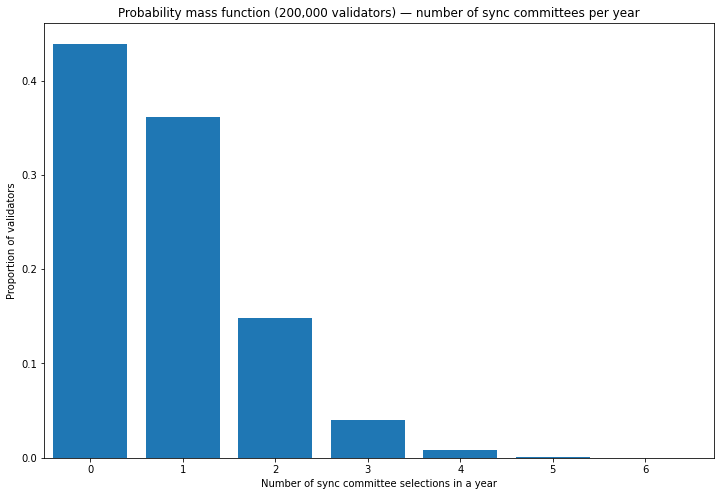

In [3]:
# plot pdf

from scipy.stats import binom

SECONDS_PER_YEAR = 31556952
SECONDS_PER_SLOT = 12
SLOTS_PER_EPOCH = 32
COMMITTEE_EPOCHS = 256
NUM_VALIDATORS = 200000
COMMITTEE_VALIDATORS = 512
epochs_per_year = SECONDS_PER_YEAR / (SECONDS_PER_SLOT * SLOTS_PER_EPOCH)

x = [el for el in range(7)]
p_selection = COMMITTEE_VALIDATORS / NUM_VALIDATORS
committees_per_year = epochs_per_year / COMMITTEE_EPOCHS
y = binom.pmf(x, committees_per_year, p_selection)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x, y)
ax.set_xlim(xmin=-0.5)
ax.set_ylim(ymin=0)
ax.set_title('Probability mass function (200,000 validators) — number of sync committees per year')
ax.set_xlabel('Number of sync committee selections in a year')
ax.set_ylabel('Proportion of validators')

print(y[0])

So with 200,000 active validators, almost half of the validators will not be selected for a single beacon committee over the course of a year. If the size of the validator set continues to increase, the probability of being selected for a validator committee will drop even lower.

# Modelling Perfect Participation

With this in mind, let's start by modelling the distribution of possible annual rewards available, assuming all validators execute their duties perfectly. Recall that in a pre-Altair world, even under perfect participation, there was variability in the validator rewards due to the random allocation of proposer duties. After Altair, the value of block proposals increases by a factor of 4 (from 3.1% of total issuance up to 12.5%), so the variability in validator rewards will accordingly increase. The introduction of sync committees is an additional source of variation in validator rewards.

Since sync committee rewards occur randomly and independently of proposer rewards, we can calculate the distribution of total annual rewards by calculating every possible combination of `num_proposer_duties` and `num_sync_committees` in a year, multiplying together the probabilities from each distribution and summing the reward amounts. We can then compare this distribution to the simple binomial distribution which describes the variation in validator rewards pre-Altair.

Pre-altair annual reward statistics (ETH)
-----------------------------------------
             median: 2.1031
               mean: 2.1038
 standard deviation: 0.0181
interquartile range: 0.0200

Altair annual reward statistics (ETH)
-------------------------------------
             median: 2.0951
               mean: 2.1038
 standard deviation: 0.1025
interquartile range: 0.1400

relative spread: 5.7 (standard deviation) / 7.0 (interquartile range)


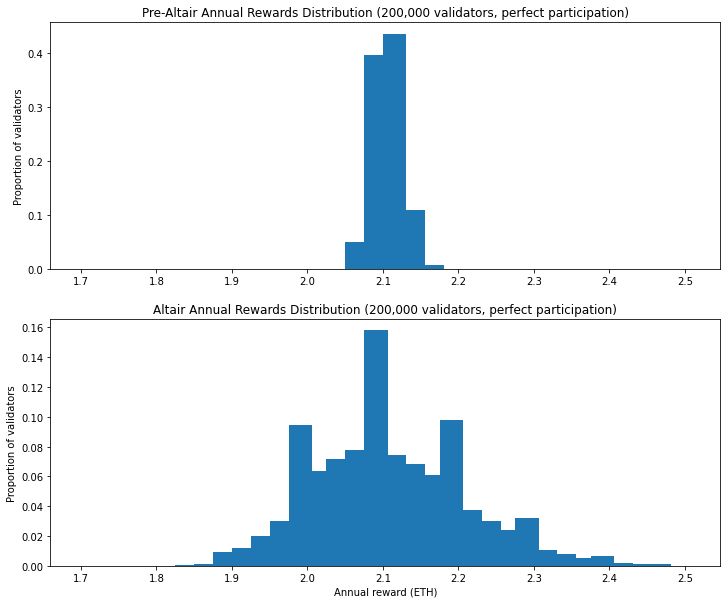

In [4]:
# model annual rewards for perfect participation

import math
import pandas as pd

def get_quantile(pmf, quantile):
    cumulative = 0
    for x, prob in sorted(pmf.items()):
        cumulative += prob
        if cumulative >= quantile:
            return x

slots_per_year = SECONDS_PER_YEAR / SECONDS_PER_SLOT

GWEI_PER_ETH = int(1e9)
gwei_per_validator = 32 * GWEI_PER_ETH
BASE_REWARD_FACTOR = 64
PREALTAIR_NUM_BASE_REWARDS = 4
PREALTAIR_PROPOSER_REWARD_QUOTIENT = 8

base_reward = gwei_per_validator * BASE_REWARD_FACTOR // math.isqrt(NUM_VALIDATORS * gwei_per_validator)
total_reward = base_reward * NUM_VALIDATORS

prior_proposer_share = base_reward // PREALTAIR_NUM_BASE_REWARDS // PREALTAIR_PROPOSER_REWARD_QUOTIENT
prior_proposer_reward = prior_proposer_share * NUM_VALIDATORS // SLOTS_PER_EPOCH
prior_att_reward = base_reward - prior_proposer_share

altair_proposer_reward = total_reward * PROPOSER_WEIGHT // SLOTS_PER_EPOCH // WEIGHT_DENOMINATOR
altair_att_reward = base_reward * (HEAD_WEIGHT + SOURCE_WEIGHT + TARGET_WEIGHT) // WEIGHT_DENOMINATOR
sync_reward = total_reward * COMMITTEE_EPOCHS * SYNC_WEIGHT // COMMITTEE_VALIDATORS // WEIGHT_DENOMINATOR

# distribution of committee selections per year
n_committees = [el for el in range(11)]
pmf_committees = binom.pmf(n_committees, committees_per_year, COMMITTEE_VALIDATORS / NUM_VALIDATORS)

# distribution of block proposal opportunities per year
n_proposals = [el for el in range(51)]
pmf_proposals = binom.pmf(n_proposals, slots_per_year, 1 / NUM_VALIDATORS)

n_bins = 32
bins = [1.7 + i / 40 for i in range(n_bins)]
altair_hist = [0] * n_bins
prior_hist = [0] * n_bins

# calculate all possible reward levels (up to 50 block proposals) assuming perfect participation
prior_pmf = {}
for props in n_proposals:
    reward = props * prior_proposer_reward + epochs_per_year * prior_att_reward
    prior_pmf[reward] = pmf_proposals[props]

# bin the rewards to generate histogram
for reward_gwei, prob in prior_pmf.items():
    reward = reward_gwei / GWEI_PER_ETH
    for i, edge in enumerate(bins[1:]):
        if reward < edge:
            prior_hist[i] += prob
            break

prior_mean = sum([p * r / GWEI_PER_ETH for r, p in prior_pmf.items()])
prior_sigma = math.sqrt(sum([p * (r / GWEI_PER_ETH)**2 for r, p in prior_pmf.items()]) - prior_mean**2)
prior_lq = get_quantile(prior_pmf, 0.25) / GWEI_PER_ETH
prior_median = get_quantile(prior_pmf, 0.5) / GWEI_PER_ETH
prior_uq = get_quantile(prior_pmf, 0.75) / GWEI_PER_ETH
prior_iqr = prior_uq - prior_lq

print('Pre-altair annual reward statistics (ETH)')
print('-----------------------------------------')
print(f'             median: {prior_median:.4f}')
print(f'               mean: {prior_mean:.4f}')
print(f' standard deviation: {prior_sigma:.4f}')
print(f'interquartile range: {prior_iqr:.4f}')
#print(sum(prior_hist)) # check histogram sums to unity

# calculate all possible reward levels (up to 50 block proposals and 10 committee selections)
altair_pmf = {}
for comms in n_committees:
    for props in n_proposals:
        reward = comms * sync_reward + props * altair_proposer_reward + epochs_per_year * altair_att_reward
        prob = pmf_committees[comms] * pmf_proposals[props]
        if reward in altair_pmf:
            altair_pmf[reward] += prob
        else:
            altair_pmf[reward] = prob

# bin the rewards to generate histogram
for reward_gwei, prob in altair_pmf.items():
    reward = reward_gwei / GWEI_PER_ETH
    for i, edge in enumerate(bins[1:]):
        if reward < edge:
            altair_hist[i] += prob
            break

altair_mean = sum([p * r / GWEI_PER_ETH for r, p in altair_pmf.items()])
altair_sigma = math.sqrt(sum([p * (r / GWEI_PER_ETH)**2 for r, p in altair_pmf.items()]) - altair_mean**2)
altair_lq = get_quantile(altair_pmf, 0.25) / GWEI_PER_ETH
altair_median = get_quantile(altair_pmf, 0.5) / GWEI_PER_ETH
altair_uq = get_quantile(altair_pmf, 0.75) / GWEI_PER_ETH
altair_iqr = altair_uq - altair_lq

print('\nAltair annual reward statistics (ETH)')
print('-------------------------------------')
print(f'             median: {altair_median:.4f}')
print(f'               mean: {altair_mean:.4f}')
print(f' standard deviation: {altair_sigma:.4f}')
print(f'interquartile range: {altair_iqr:.4f}')
#print(sum(altair_hist)) # check histogram sums to unity

print(f'\nrelative spread: {altair_sigma / prior_sigma:.1f} (standard deviation) / '
      f'{altair_iqr / prior_iqr:.1f} (interquartile range)')

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,10))
ax1.bar(bins, prior_hist, 1 / n_bins, align='edge')
ax1.set_title('Pre-Altair Annual Rewards Distribution (200,000 validators, perfect participation)')
ax1.set_ylabel('Proportion of validators')
ax2.bar(bins, altair_hist, 1 / n_bins, align='edge')
ax2.set_title('Altair Annual Rewards Distribution (200,000 validators, perfect participation)')
ax2.set_xlabel('Annual reward (ETH)')
ax2.set_ylabel('Proportion of validators')

ax.set_title('Distribution of annual rewards assuming perfect performance')
ax.set_xlabel('Annual reward (ETH)')
ax.set_ylabel('Proportion of validators');

As expected, the statistics and charts above show that with perfect participation, although the mean issuance is unchanged by Altair, the spread of rewards is increased significantly, with a 5.7 factor increase in the standard deviation of rewards in Altair, as compared with the pre-Altair spread.

# Penalties

The changes in reward weights in Altair are matched by equivalent changes to the weights of penalties for missed or incorrect attestations. But more significant than the weightings is the way in which delayed attestations are treated. If an attestation is not included in the earliest possible slot, then the validator will be treated as not having participated for some or all of the components of the attestation, leading to penalties for those components that were late.

This is an important difference. Consider for example an attestation which is correct, but is included one slot 'late'. Before Altair, this attestation would receive the maximum reward for the source, target and head votes, and half of the 'delay' reward. Altogether this would have amounted to approximately 90% of the maximum available reward for the attesation. However, under Altair's rules, the validator will be treated as though the head vote was incorrect, and will be penalised. Therefore, at best an attestation which is one slot late will receive 48% of the maximum available reward.

Attestations which are too late to receive the source reward (i.e. with a delay of greater than 5 slots) will result at best in zero total reward under Altair (and may be overall negative), whereas the same attestation pre-Altair would have received up to 77% of the maximum reward. In short, penalties for late attestations are much more severe under Altair. Under situations of network stress as have frequently been observed on testnets with lower-participation rates, even completely reliable validators are likely to be punished.

## Slashing and Inactivity Penalties

In addition to the penalty weights and delay mechanism a few changes have been made to the slashing and inactivity leak parameters. Since neither of these factors are being modelled here (the conditions for inactivity leak have never occurred on mainnet, and slashing is rare and easily avoided by users with a standard set up), they will not be covered here. See [Vitalik Buterin's annotated spec](https://github.com/ethereum/annotated-spec/blob/master/altair/beacon-chain.md#introduction) for further details.

# Mainnet Data

For a more realistic direct comparison between the pre-Altair and post-Altair reward schemes, we'd like to have some real world data. Fortunately, the existing mainnet data is similar enough that, if we make a few assumptions, we can compare how validators would have been rewarded under Altair, with the rewards they actually received.

## Methodology

For ease, we're going to use the data from the first 32,000 epochs of the beacon chain (the same dataset as in the previous article). This means our data covers the first 4½ months of the beacon chain's operation up until [22 April](https://beaconcha.in/epoch/32000). Then, for each epoch, we'll calculate the rewards available for correct (and timely) source, target and head votes. Using the epoch summary data provided by [chaind](https://github.com/wealdtech/chaind), we can see whether each vaildator voted correctly, and how many slots delayed the attestation was included. We can use this information, along with the updated `base_reward` calculation and weightings, to work out what rewards and/or penalties the validator would have received, had the Altair reward scheme been in place.

Second, we need to simulate the sync committee and make some guess as to how each vaildator would have performed, if selected for a sync committee. For this analysis, 512 validators are selected at random every 256 epochs, and their performance in the sync committee for each epoch is assumed to perfect if they successfully attested in that epoch, or non-existent otherwise.

Finally, we can use the previously-calculated proposer rewards. These are simply multiplied by 4 to get the proposer reward which would have applied under Altair. These steps have been implemented in a [Python script](altair_sim.py) with the results saved to JSON files.

## Assumptions

So, clearly a number of assumptions are made in order to do this comparison, such as:

* the blocks proposed are identical, containing the same number of attestations and therefore worth exactly 4 times as much under Altair compared with the previous rules
* attestation inclusion occurs at the same time under Altair as it did under the previous rules (i.e. changes to epoch processing, client optimisations etc. which may have altered the speed at which attestations are included are not considered here)

And the by far the weakest assumption:

* each sync committee participant would have successfully performed their duties for the entire epoch if in that epoch the validator submitted an attestation

This last assumption is the shakiest one — we're assuming that validators who successfully submitted an attestation, even if delayed, would have successfully participated for the whole epoch (i.e. 32 times). In some cases, then, this will be a generous assumption about validators' performance (even if they submitted an attestation that epoch, we cannot be sure that they would have flawlessly participated in the sync committee for each slot). On the other hand, in some cases this will be an excessively harsh assumption, since validators who failed to attest in a given epoch might still have successfully participated in the sync committee for some or all of the slots.

With all this in mind, let's take a look at the data.

Statistics — first 32,000 epochs (pre-Altair rewards scheme, measured in ETH)
-----------------------------------------------------------------------------
             median: 1.3572
               mean: 1.3385
 standard deviation: 0.0990
interquartile range: 0.0300

Statistics — first 32,000 epochs (Altair rewards scheme, measured in ETH)
-------------------------------------------------------------------------
             median: 1.0719
               mean: 1.0687
 standard deviation: 0.1065
interquartile range: 0.0923

Comaprisons
-----------
Mean rewards under Altair were 0.2699 ETH (20.2%) lower
The interquartile range (spread) of rewards under Altair was 3.1 times greater


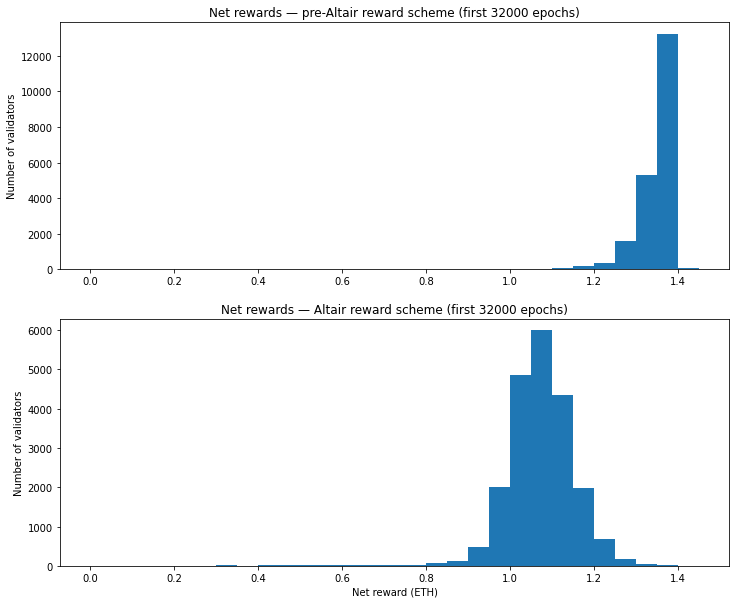

In [5]:
# calculate stats and plot data for net rewards under pre-Altair and Altair reward schemes

import json

with open('rewards.json') as f:
    rewards = json.load(f)
with open('check.json') as f:
    check = json.load(f)

# we're using the "reduced genesis set" of validators as in the previous article

with open('reduced_genesis_set.json') as f:
    reduced_genesis_set = json.load(f)

altair_rewards = []
prior_rewards = []
for validator_index in reduced_genesis_set:
    altair_rewards += [rewards[str(validator_index)] / 1e9]
    prior_rewards += [check[str(validator_index)] / 1e9]

df = pd.DataFrame({'altair_rewards': altair_rewards, 'prior_rewards': prior_rewards})

prior_iqr = df['prior_rewards'].quantile(0.75) - df['prior_rewards'].quantile(0.25)
altair_iqr = df['altair_rewards'].quantile(0.75) - df['altair_rewards'].quantile(0.25)
prior_mean = df["prior_rewards"].mean()
altair_mean = df["altair_rewards"].mean()
mean_diff = prior_mean - altair_mean

print('Statistics — first 32,000 epochs (pre-Altair rewards scheme, measured in ETH)')
print('-----------------------------------------------------------------------------')
print(f'             median: {df["prior_rewards"].quantile(0.5):.4f}')
print(f'               mean: {prior_mean:.4f}')
print(f' standard deviation: {df["prior_rewards"].std():.4f}')
print(f'interquartile range: {prior_iqr:.4f}')

print('\nStatistics — first 32,000 epochs (Altair rewards scheme, measured in ETH)')
print('-------------------------------------------------------------------------')
print(f'             median: {df["altair_rewards"].quantile(0.5):.4f}')
print(f'               mean: {altair_mean:.4f}')
print(f' standard deviation: {df["altair_rewards"].std():.4f}')
print(f'interquartile range: {altair_iqr:.4f}')

print('\nComaprisons')
print('-----------')
print(f'Mean rewards under Altair were {mean_diff:.4f} ETH ({100*mean_diff/prior_mean:.1f}%) lower')
print(f'The interquartile range (spread) of rewards under Altair was {altair_iqr / prior_iqr:.1f} times greater')

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,10))
bins = [b/20 for b in range(30)]
df['prior_rewards'].plot.hist(ax=ax1, bins=bins)
df['altair_rewards'].plot.hist(ax=ax2, bins=bins)
ax1.set_title("Net rewards — pre-Altair reward scheme (first 32000 epochs)")
ax1.set_ylabel("Number of validators")
ax2.set_title("Net rewards — Altair reward scheme (first 32000 epochs)")
ax2.set_xlabel("Net reward (ETH)")
ax2.set_ylabel("Number of validators");

# Analysis

Clearly the Altair rules are less forgiving than the previous scheme, since the mean reward drops by a fifth when they are applied to this dataset. As hinted earlier, this is due to the impact of the harsher penalties for delayed attestations.

Also as predicted, the spread of rewards is greater under Altair. Curiously, although clearly visible in the histograms above, this effect is not evident in the comparison between standard deviations, which are almost identical for the two datasets. This presumably is due to the influence of outliers (e.g. a few harshly penalised validators who have never submitted an attestation). However, when comparing the the more robust interquartile range, we see a three times greater spread in rewards for Altair than the previous scheme. This is not as great as the 7 times increase in spread predicted from our modelling of perfect validators. This is because the variability in rewards in real data is due not only to the random allocation of proposer/sync duties, but also due to imperfect performance of validators, with the result that the real data in the pre-Altair case had a greater spread to start with than in the modelled perfect data, so the increase in variability from Altair is not so pronounced.

It's interesting to consider whether such a pronounced impact will become apparent when Altair is launched on mainnet. Client improvements already implemented may already have reduced the inclusion delay for attestations, which was the source of the reduction in mean rewards observed here.

# Conclusions

As was seen from our initial modelling, the four-fold increase in the proposer reward, and the introduction of the sync committee will  contribute to a greater variability of rewards than is currently the case. This variability will have a greater impact on solo validators than large staking pools (whose rewards will be closer to the average). This effect should be borne in mind when considering any future changes which could impact the structure of validator rewards (such as the future introduction of sharding).

Additionally, on the basis of the analysis above, it appears likely that some reduction in mean rewards will occur when Altair goes live, even though the changes introduced are neutral in terms of the maximum rewards available. This impact will be felt most keenly by those validators whose attestations have a tendency to be included late, perhaps due to network latency. Validators would therefore be well advised to keep a close eye on their performance before and after Altair goes live.


# Acknowledgements
Many thanks to Lido finance for funding this work through their [ecosystem grants programme](https://research.lido.fi/t/legos-first-three-months/786).